In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import random
import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir='/content/drive/My Drive/Shop DataSet'
filepath=[]
labels=[]
folds=os.listdir(data_dir)
for fold in folds:
    fpath=os.path.join(data_dir,fold)
    fpaths=os.listdir(fpath)
    for f in fpaths:
        fpa=os.path.join(fpath,f)
        filepath.append(fpa)
        labels.append(fold)
fseries=pd.Series(filepath,name='video_name')
lseries=pd.Series(labels,name='labels')
df=pd.concat([fseries,lseries],axis=1)
df

,video_name,labels
0,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
1,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
2,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
3,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
4,/content/drive/My Drive/Shop DataSet/shop lift...,shop lifters
...,...,...
850,/content/drive/My Drive/Shop DataSet/non shop ...,non shop lifters
851,/content/drive/My Drive/Shop DataSet/non shop ...,non shop lifters
852,/content/drive/My Drive/Shop DataSet/non shop ...,non shop lifters
853,/content/drive/My Drive/Shop DataSet/non shop ...,non shop lifters


In [4]:
df['labels'].value_counts()

,count
labels,
non shop lifters,531
shop lifters,324


In [5]:
train_df,dummy_df=train_test_split(df,test_size=0.2,random_state=42,stratify=df['labels'])
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=dummy_df['labels'])
train_df.shape,valid_df.shape,test_df.shape

((684, 2), (85, 2), (86, 2))

In [6]:
class VideoDataGenerator(Sequence):
    def __init__(self, df, batch_size, img_size, frame_count, shuffle=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.frame_count = frame_count
        self.shuffle = shuffle
        self.augment = augment

        # Convert categorical labels to integers
        self.label_encoder = LabelEncoder()
        self.df['labels'] = self.label_encoder.fit_transform(self.df['labels'])  # Encode labels as integers
        self.num_classes = len(self.label_encoder.classes_)

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_data)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_data):
        X = []
        y = []
        for _, row in batch_data.iterrows():
            cap = cv2.VideoCapture(row['video_name'])
            frames = []
            for _ in range(self.frame_count):
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, self.img_size)
                if self.augment:
                    if random.random() > 0.5:
                        frame = cv2.flip(frame, 1)  # Random horizontal flip
                    angle = random.randint(-10, 10)
                    M = cv2.getRotationMatrix2D((self.img_size[0]//2, self.img_size[1]//2), angle, 1)
                    frame = cv2.warpAffine(frame, M, self.img_size)
                frames.append(frame / 255.0)
            cap.release()

            while len(frames) < self.frame_count:
                frames.append(np.zeros((self.img_size[0], self.img_size[1], 3)))

            X.append(np.array(frames))
            y.append(row['labels'])

        return np.array(X), to_categorical(np.array(y), num_classes=self.num_classes)


In [7]:
BATCH_SIZE = 4
IMG_SIZE = (64, 64)
FRAME_COUNT = 20

train_gen = VideoDataGenerator(train_df, BATCH_SIZE, IMG_SIZE, FRAME_COUNT, shuffle=True, augment=True)
val_gen = VideoDataGenerator(valid_df, BATCH_SIZE, IMG_SIZE, FRAME_COUNT, shuffle=False, augment=False)
test_gen = VideoDataGenerator(test_df, BATCH_SIZE, IMG_SIZE, FRAME_COUNT, shuffle=False, augment=False)

num_classes = train_gen.num_classes

In [8]:
base_cnn = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Unfreeze last 10 layers for fine-tuning
for layer in base_cnn.layers[-10:]:
    layer.trainable = True

model = Sequential([
    TimeDistributed(base_cnn, input_shape=(FRAME_COUNT, IMG_SIZE[0], IMG_SIZE[1], 3)),
    TimeDistributed(Flatten()),

    LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # L2 Regularization
    Dropout(0.5),  # Increased dropout
    Dense(num_classes, activation='softmax')
])

# Compile model with a lower learning rate for fine-tuning
model.compile(optimizer=Adamax(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 2, 2, 1280)      │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 5120)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │       1,327,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,381,221 (20.53 MB)

 Trainable params: 5,339,198 (20.37 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [10]:
history=model.fit(train_gen,epochs=15,validation_data=val_gen)

Epoch 1/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 652s 1s/step - accuracy: 0.5727 - loss: 1.2935 - val_accuracy: 0.7143 - val_loss: 1.1389
Epoch 2/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 164s 960ms/step - accuracy: 0.7031 - loss: 1.0941 - val_accuracy: 0.5119 - val_loss: 1.3116
Epoch 3/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 165s 964ms/step - accuracy: 0.7952 - loss: 0.9030 - val_accuracy: 0.5119 - val_loss: 1.3208
Epoch 4/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 168s 981ms/step - accuracy: 0.8747 - loss: 0.7560 - val_accuracy: 0.5952 - val_loss: 1.0877
Epoch 5/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 164s 961ms/step - accuracy: 0.8867 - loss: 0.7192 - val_accuracy: 0.8095 - val_loss: 0.8293
Epoch 6/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 166s 971ms/step - accuracy: 0.8985 - loss: 0.6271 - val_accuracy: 0.6190 - val_loss: 1.0953
Epoch 7/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 166s 969ms/step - accuracy: 0.9262 - loss: 0.5453 - val_accuracy: 0.7857 - val_loss: 0.9235
Epoch 8/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 167s 973ms/step - accuracy: 0.9514 - lo

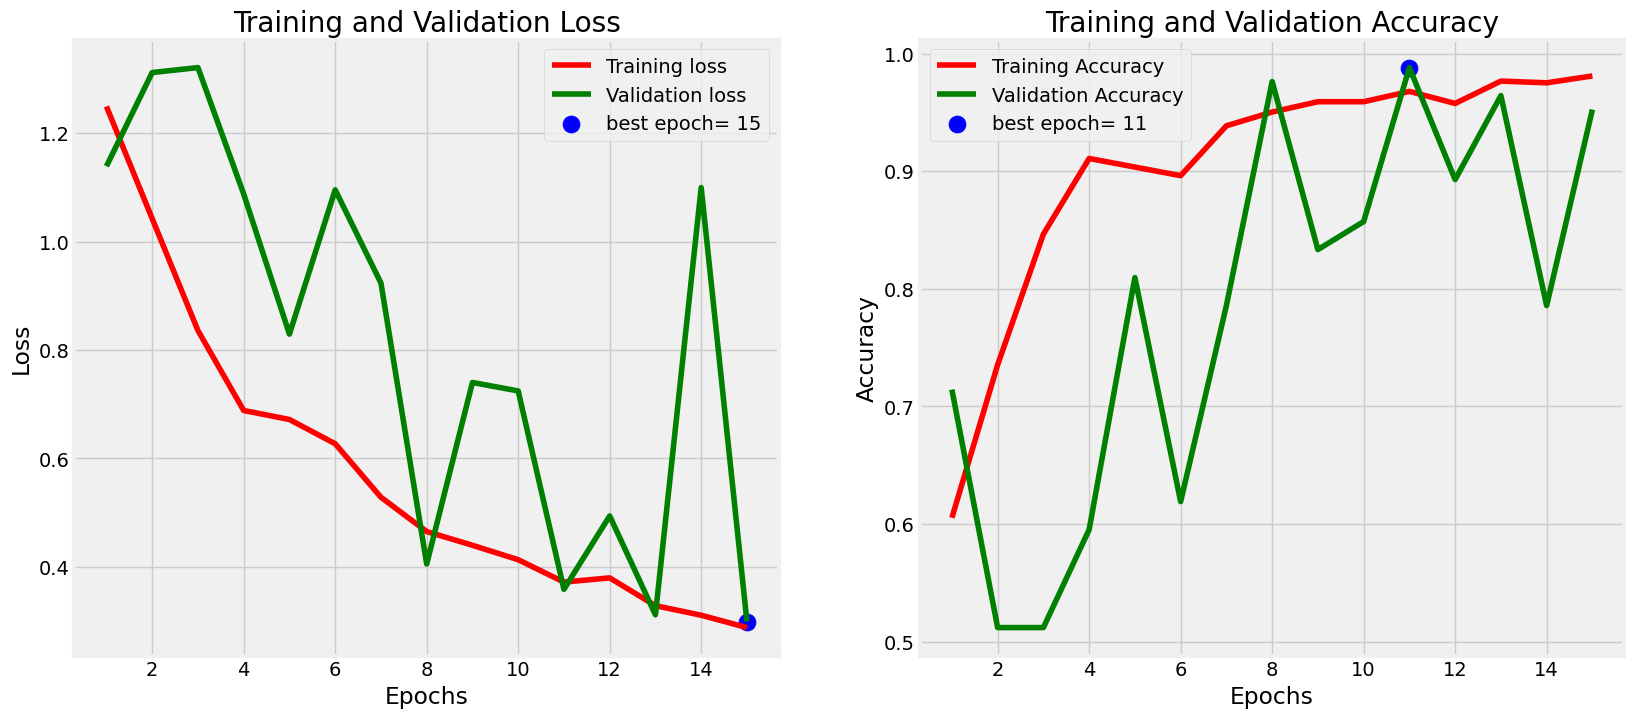

In [11]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(val_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 1.0000 - loss: 0.2217
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.8333 - loss: 0.4205
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.9167 - loss: 0.4633
Train Loss:  0.22176000475883484
Train Accuracy:  1.0
--------------------
Valid Loss:  0.3710578680038452
Valid Accuracy:  0.875
--------------------
Test Loss:  0.5673174262046814
Test Accuracy:  0.875


In [13]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 309ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


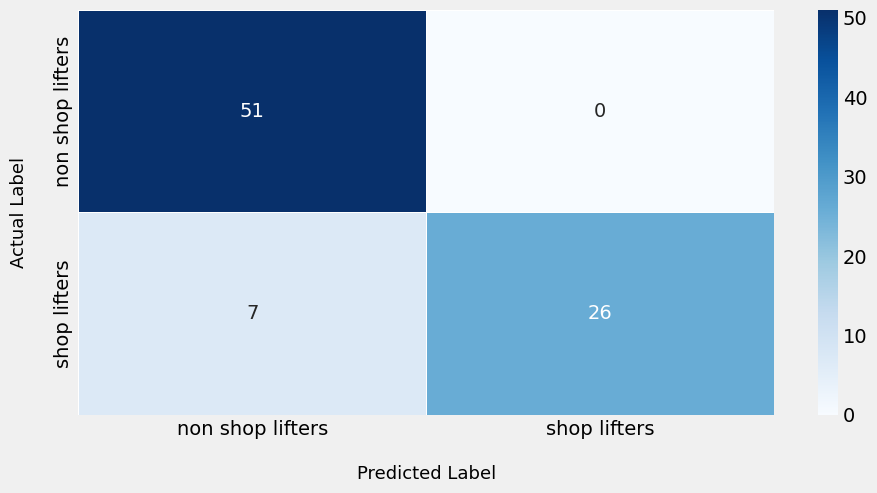

In [14]:
y_pred_all = []
y_true_all = []

for i in range(len(test_gen)):
    x, y_true = test_gen[i]
    preds = model.predict(x)
    y_pred_all.extend(np.argmax(preds, axis=1))
    y_true_all.extend(np.argmax(y_true, axis=1))

y_pred_all = np.array(y_pred_all)
y_true_all = np.array(y_true_all)
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_true_all, y_pred_all)
labels = list(test_gen.label_encoder.classes_)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label', fontsize=13)
plt.ylabel('Actual Label\n', fontsize=13)
plt.show()

In [15]:
print(classification_report(y_true_all, y_pred_all, target_names=test_gen.label_encoder.classes_))

                  precision    recall  f1-score   support

non shop lifters       0.88      1.00      0.94        51
    shop lifters       1.00      0.79      0.88        33

        accuracy                           0.92        84
       macro avg       0.94      0.89      0.91        84
    weighted avg       0.93      0.92      0.91        84



In [1]:
model.save('video_classificationpretrain.h5')

NameError: name 'model' is not defined